# CNN-Based Object Recognition on the RGB-D Object Dataset

This notebook implements a Convolutional Neural Network (CNN) for object classification using the RGB images from the RGB-D Object Dataset. The goal is to recognize various object categories (e.g., apple, ball, etc.) using RGB, depth and mask data.

We will perform the following steps:
1. Load and preprocess the dataset
2. Encode labels and split into training and validation sets
3. Define a CNN architecture
4. Train the model and monitor performance
5. Evaluate the model with accuracy metrics and confusion matrix
6. Experiment with different hyperparameters

## Import Required Libraries

In [1]:
# Standard libraries
import os
import numpy as np
from pathlib import Path
from PIL import Image
import logging
import random
from collections import Counter, defaultdict

# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

# Plotting and utility
import matplotlib.pyplot as plt


In [2]:
print(torch.__version__)

2.7.0+cu126


## Load Image Paths and Extract Labels

In [3]:
# Set up logging for skipped samples
logging.basicConfig(filename='skipped_samples.log', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# Define dataset root
DATASET_ROOT = Path("data/rgbd-dataset")

# List all object categories
categories = sorted([d.name for d in DATASET_ROOT.iterdir() if d.is_dir()])
print(f"Found {len(categories)} categories: {categories}")
if len(categories) != 15:
    raise ValueError(f"Expected 15 categories, but found {len(categories)}")

# Collect image paths, labels, and instance mapping
image_paths = []
labels = []
instance_to_images = {}  # Maps instance (category/instance_name) to list of image paths

for label, category in enumerate(categories):
    category_path = DATASET_ROOT / category
    for instance_dir in category_path.iterdir():
        if not instance_dir.is_dir():
            continue
        instance_name = f"{category}/{instance_dir.name}"
        instance_to_images[instance_name] = []
        for file in instance_dir.glob("*_crop.png"):
            if not file.name.endswith(("_depthcrop.png", "_maskcrop.png")):
                image_paths.append(file)
                labels.append(label)
                instance_to_images[instance_name].append(file)

print(f"Total RGB images found: {len(image_paths)}")
print(f"Total instances found: {len(instance_to_images)}")
if not image_paths:
    raise ValueError("No RGB images found in the dataset. Check DATASET_ROOT and file structure.")


Found 15 categories: ['ball', 'bell_pepper', 'bowl', 'coffee_mug', 'dry_battery', 'food_bag', 'food_can', 'food_jar', 'garlic', 'glue_stick', 'instant_noodles', 'plate', 'stapler', 'tomato', 'water_bottle']
Total RGB images found: 73416
Total instances found: 105


## Create a Custom Dataset Class

In [4]:
class RGBDObjectDataset(Dataset):
    """
    PyTorch Dataset for the RGB-D Object Dataset (crops with segmentation masks).

    Each sample include:
      - RGB image (cropped color image)
      - Depth image (cropped depth map)
      - Segmentation mask (object mask)

    Args:
        root_dir (str): Root directory of the dataset. Assumes subfolders per class, e.g.:
                        root_dir/
                          class1/
                            instanceA/
                              class1_instA_1_rgbcrop.png
                              class1_instA_1_depthcrop.png
                              class1_instA_1_maskcrop.png
                              ...
                            instanceB/
                              ...
                          class2/
                            ...
        mode (str): Specifies which modalities to output. 
                    Can be 'rgb', 'depth', 'mask', or combinations with '+', e.g. 'rgb+depth'.
        transform_rgb (callable, optional): Transform to apply to RGB images.
        transform_depth (callable, optional): Transform to apply to depth images.
        transform_mask (callable, optional): Transform to apply to mask images.
    """
    def __init__(self, root_dir, mode='rgb', transform=None):
        """
        root_dir: root directory of the dataset, i.e. 'data/rgbd-dataset'
        mode: one of ['rgb', 'rgb+depth', 'rgb+depth+mask']
        """
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        # Modes supported
        valid_modes = ['rgb', 'rgb+depth', 'rgb+depth+mask', 'rgb+mask']
        if mode not in valid_modes:
            raise ValueError(f"Invalid mode: {mode}, must be one of {valid_modes}")
        self.modalities = mode.split('+')

        self.samples = []
        self.class_to_idx = {}
        self._load_dataset()
        print(f"Loaded {len(self.samples)} samples in RGBDObjectDataset")

    def _load_dataset(self):
        class_names = sorted(os.listdir(self.root_dir))
        for idx, class_name in enumerate(class_names):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            self.class_to_idx[class_name] = idx
            for instance_name in os.listdir(class_path):
                inst_dir = os.path.join(class_path, instance_name)
                if not os.path.isdir(inst_dir):
                    continue

                # Gather all _crop.png filenames (excluding depthcrop and maskcrop)
                prefixes = set()
                for fname in os.listdir(inst_dir):
                    if fname.endswith('_crop.png') and not fname.endswith(('_depthcrop.png', '_maskcrop.png')):
                        prefixes.add(fname[:-len('_crop.png')])

                for prefix in prefixes:
                    rgb_path = os.path.join(inst_dir, prefix + '_crop.png') if 'rgb' in self.modalities else None
                    depth_path = os.path.join(inst_dir, prefix + '_depthcrop.png') if 'depth' in self.modalities else None
                    mask_path = os.path.join(inst_dir, prefix + '_maskcrop.png') if 'mask' in self.modalities else None

                    # Verify all required files exist
                    if (('rgb' in self.modalities and (not rgb_path or not os.path.isfile(rgb_path))) or
                        ('depth' in self.modalities and (not depth_path or not os.path.isfile(depth_path))) or
                        ('mask' in self.modalities and (not mask_path or not os.path.isfile(mask_path)))):
                        logging.info(f"Skipping sample {prefix} in {inst_dir}: Missing required files")
                        continue

                    self.samples.append({
                        'rgb': rgb_path,
                        'depth': depth_path,
                        'mask': mask_path,
                        'label': self.class_to_idx[class_name]
                    })

        if not self.samples:
            raise RuntimeError(f"No valid samples found for mode '{self.mode}' in {self.root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        try:
            rgb_img = Image.open(sample['rgb']).convert('RGB') if 'rgb' in self.modalities else None
            depth_img = Image.open(sample['depth']).convert('L') if 'depth' in self.modalities else None
            mask_img = Image.open(sample['mask']).convert('L') if 'mask' in self.modalities else None
        except Exception as e:
            print(f"Error loading sample {idx} (rgb: {sample['rgb']}): {e}")
            raise
        if self.transform:
            if rgb_img is not None:
                rgb_img = self.transform(rgb_img)
            if depth_img is not None:
                depth_img = self.transform(depth_img)
            if mask_img is not None:
                mask_img = self.transform(mask_img)
        inputs = []
        if rgb_img is not None:
            inputs.append(rgb_img)
        if depth_img is not None:
            inputs.append(depth_img)
        if mask_img is not None:
            inputs.append(mask_img)
        x = torch.cat(inputs, dim=0) if len(inputs) > 1 else inputs[0]
        return x, sample['label']

## Loading the Dataset in DataLoader

In [7]:
# Define transforms for RGB and depth images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset for RGB+Depth+Mask
train_dataset = RGBDObjectDataset(root_dir='data/rgbd-dataset', mode='rgb+depth+mask', transform=train_transform)
val_dataset = RGBDObjectDataset(root_dir='data/rgbd-dataset', mode='rgb+depth+mask', transform=val_transform)

# Check if either dataset is empty
if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("Dataset is empty. Check file paths and dataset loading logic.")

# Group samples by instance
instance_to_indices = {}
for idx, sample in enumerate(train_dataset.samples):
    rgb_path = Path(sample['rgb'])
    # Extract category and instance using Path parts
    instance = f"{rgb_path.parts[-3]}/{rgb_path.parts[-2]}"
    if instance not in instance_to_indices:
        instance_to_indices[instance] = []
    instance_to_indices[instance].append(idx)

print(f"Number of instances in dataset: {len(instance_to_indices)}")
if not instance_to_indices:
    raise ValueError("No instances found in dataset. Check instance grouping logic.")

# Stratified Split instances by class
class_to_instances = defaultdict(list)
for instance in instance_to_images.keys():
    class_name = instance.split('/')[0]
    class_to_instances[class_name].append(instance)

train_instances = []
val_instances = []
train_ratio = 0.8
for class_name, instances in class_to_instances.items():
    random.shuffle(instances)
    train_count = max(1, int(train_ratio * len(instances)))
    train_instances.extend(instances[:train_count])
    val_instances.extend(instances[train_count:])

# Collect indices for train and val
train_indices = []
val_indices = []
for instance in train_instances:
    train_indices.extend(instance_to_indices[instance])
for instance in val_instances:
    val_indices.extend(instance_to_indices[instance])

print(f"Training indices: {len(train_indices)}")
print(f"Validation indices: {len(val_indices)}")
if not train_indices:
    raise ValueError("No training indices assigned. Check instance splitting logic.")
if not val_indices:
    raise ValueError("No validation indices assigned. Check instance splitting logic.")

# Create Subset datasets
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(val_dataset, val_indices)

# Additional diagnostic
print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
if len(train_subset) + len(val_subset) != len(train_dataset):
    print(f"Warning: Subset sizes ({len(train_subset)} + {len(val_subset)}) do not match total dataset size ({len(train_dataset)})")

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=True, pin_memory=True)

print(f"Training subset size: {len(train_subset)} images")
print(f"Validation subset size: {len(val_subset)} images")

for batch, labels in train_loader:
    print(batch.shape, labels.shape)
    break

Loaded 73292 samples in RGBDObjectDataset
Loaded 73292 samples in RGBDObjectDataset
Number of instances in dataset: 105
Training indices: 52205
Validation indices: 21087
Training subset size: 52205
Validation subset size: 21087
Training subset size: 52205 images
Validation subset size: 21087 images
torch.Size([128, 5, 224, 224]) torch.Size([128])


## Diagnostic Checks

In [9]:
def run_diagnostic_checks(train_dataset, val_dataset, train_loader, val_loader, categories, instance_to_images):
    print("\n=== Running Diagnostic Checks ===")

    # 1. Check for Data Leakage: Image Path Overlap
    train_indices = train_dataset.indices
    val_indices = val_dataset.indices
    train_paths = [train_dataset.dataset.samples[i]['rgb'] for i in train_indices]
    val_paths = [val_dataset.dataset.samples[i]['rgb'] for i in val_indices]
    common_paths = set(train_paths) & set(val_paths)
    print(f"Number of overlapping image paths between train and val: {len(common_paths)}")
    if common_paths:
        print(f"Example overlapping paths: {list(common_paths)[:5]}")
        raise ValueError("Data leakage detected: Overlapping images in train and val sets")

    # 2. Check for Data Leakage: Instance-Level Separation
    train_instances = set()
    val_instances = set()
    for i in train_indices:
        rgb_path = Path(train_dataset.dataset.samples[i]['rgb'])
        instance = f"{rgb_path.parts[-3]}/{rgb_path.parts[-2]}"
        train_instances.add(instance)
    for i in val_indices:
        rgb_path = Path(val_dataset.dataset.samples[i]['rgb'])
        instance = f"{rgb_path.parts[-3]}/{rgb_path.parts[-2]}"
        val_instances.add(instance)
    common_instances = train_instances & val_instances
    print(f"Number of overlapping instances between train and val: {len(common_instances)}")
    if common_instances:
        print(f"Example overlapping instances: {list(common_instances)[:5]}")
        raise ValueError("Data leakage detected: Overlapping instances in train and val sets")

    # 3. Validate Dataset Usage: Class Count
    print(f"Number of classes in dataset: {len(categories)}")
    if len(categories) != 15:
        raise ValueError(f"Expected 15 classes, found {len(categories)}")

    # 4. Validate Dataset Usage: Label Distribution
    train_labels = [train_dataset.dataset.samples[i]['label'] for i in train_indices]
    val_labels = [val_dataset.dataset.samples[i]['label'] for i in val_indices]
    train_label_counts = Counter(train_labels)
    val_label_counts = Counter(val_labels)
    print("\nLabel distribution in training set:")
    for label in range(15):
        count = train_label_counts.get(label, 0)
        print(f"Class {label} ({categories[label]}): {count} samples")
    print("\nLabel distribution in validation set:")
    for label in range(15):
        count = val_label_counts.get(label, 0)
        print(f"Class {label} ({categories[label]}): {count} samples")

    # 5. Validate Dataset Usage: Input Channels
    sample_input, _ = train_dataset[0]
    print(f"\nSample input shape: {sample_input.shape}")
    if sample_input.shape[0] != 5:
        raise ValueError(f"Expected 5 channels, found {sample_input.shape[0]}")

    # 6. Implementation Error Check: Batch Shape Verification
    for batch, labels in train_loader:
        print(f"\nTrain batch shape: {batch.shape}, Labels shape: {labels.shape}")
        print(f"Label range: min={labels.min().item()}, max={labels.max().item()}")
        if batch.shape[1] != 5 or batch.shape[2] != 224 or batch.shape[3] != 224:
            raise ValueError(f"Unexpected batch shape: {batch.shape}")
        if labels.min().item() < 0 or labels.max().item() > 14:
            raise ValueError(f"Labels out of range: {labels.min().item()} to {labels.max().item()}")
        break

    # 7. Implementation Error Check: Prediction Sanity Check
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    old_conv = model.conv1
    model.conv1 = nn.Conv2d(5, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                            stride=old_conv.stride, padding=old_conv.padding, bias=False)
    with torch.no_grad():
        model.conv1.weight[:, :3, :, :] = old_conv.weight.clone()
        mean_weight = old_conv.weight.mean(dim=1, keepdim=True)
        model.conv1.weight[:, 3:5, :, :] = mean_weight.repeat(1, 2, 1, 1)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features, 15)  # Updated to 15 classes
    )
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch, _ in train_loader:
            batch = batch.to(device)
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
            print(f"\nSample prediction probabilities shape: {probs.shape}")
            print(f"Probability sum (first sample): {probs[0].sum().item():.4f}")
            if probs.shape[1] != 15:
                raise ValueError(f"Expected 15 classes in predictions, found {probs.shape[1]}")
            if not np.isclose(probs.sum(dim=1).cpu().numpy(), 1.0, atol=1e-4).all():
                raise ValueError("Prediction probabilities do not sum to 1")
            break

    print("\n=== All Diagnostic Checks Passed ===")

# Run diagnostics
run_diagnostic_checks(train_subset, val_subset, train_loader, val_loader, categories, instance_to_images)


=== Running Diagnostic Checks ===
Number of overlapping image paths between train and val: 0
Number of overlapping instances between train and val: 0
Number of classes in dataset: 15

Label distribution in training set:
Class 0 (ball): 3958 samples
Class 1 (bell_pepper): 2532 samples
Class 2 (bowl): 2296 samples
Class 3 (coffee_mug): 3777 samples
Class 4 (dry_battery): 2163 samples
Class 5 (food_bag): 4728 samples
Class 6 (food_can): 4014 samples
Class 7 (food_jar): 3141 samples
Class 8 (garlic): 3935 samples
Class 9 (glue_stick): 3103 samples
Class 10 (instant_noodles): 4745 samples
Class 11 (plate): 3157 samples
Class 12 (stapler): 3719 samples
Class 13 (tomato): 3935 samples
Class 14 (water_bottle): 3002 samples

Label distribution in validation set:
Class 0 (ball): 1603 samples
Class 1 (bell_pepper): 1252 samples
Class 2 (bowl): 1588 samples
Class 3 (coffee_mug): 1089 samples
Class 4 (dry_battery): 1012 samples
Class 5 (food_bag): 1574 samples
Class 6 (food_can): 1555 samples
Clas

## Model Modification for 5-Channel Input

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_classes = 15  # number of object categories

# --- ResNet50 Modification ---
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
old_conv = resnet.conv1
resnet.conv1 = nn.Conv2d(5, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                         stride=old_conv.stride, padding=old_conv.padding, bias=False)
with torch.no_grad():
    # Copy pretrained weights for first 3 channels
    resnet.conv1.weight[:, :3, :, :] = old_conv.weight.clone()
    # For channel 4 and 5, use mean of first 3 channels
    mean_weight = old_conv.weight.mean(dim=1, keepdim=True)
    resnet.conv1.weight[:, 3:5, :, :] = mean_weight.repeat(1, 2, 1, 1)
# Add dropout and new final layer
in_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Dropout(p=0.6), 
    nn.Linear(in_features, num_classes)
)
resnet = resnet.to(device)

# --- EfficientNet-B0 Modification ---
effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
old_eff_conv = effnet.features[0][0]
new_eff_conv = nn.Conv2d(5, old_eff_conv.out_channels, kernel_size=old_eff_conv.kernel_size,
                         stride=old_eff_conv.stride, padding=old_eff_conv.padding, bias=False)
with torch.no_grad():
    new_eff_conv.weight[:, :3, :, :] = old_eff_conv.weight.clone()
    mean_weight = old_eff_conv.weight.mean(dim=1, keepdim=True)
    new_eff_conv.weight[:, 3:5, :, :] = mean_weight.repeat(1, 2, 1, 1)
effnet.features[0][0] = new_eff_conv
in_features = effnet.classifier[1].in_features
effnet.classifier = nn.Sequential(
    nn.Dropout(p=0.6), 
    nn.Linear(in_features, num_classes)
)
effnet = effnet.to(device)

Using device: cuda


## Training and Evaluation Loops

In [ ]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# --- Class Weights Calculation ---
train_labels = [train_dataset.samples[i]['label'] for i in train_subset.indices]
label_counts = Counter(train_labels)
total_samples = len(train_labels)
class_weights = [total_samples / (num_classes * label_counts[i]) for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizers with weight decay
optimizer_res = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer_eff = optim.Adam(effnet.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate schedulers
scheduler_res = optim.lr_scheduler.ReduceLROnPlateau(optimizer_res, mode='min', factor=0.1, patience=5)
scheduler_eff = optim.lr_scheduler.ReduceLROnPlateau(optimizer_eff, mode='min', factor=0.1, patience=5)

# Gradient scalers for mixed precision
scaler_res = GradScaler(device='cuda')
scaler_eff = GradScaler(device='cuda')

# Parameters
best_acc_res = 0.0
best_acc_eff = 0.0
patience = 15
counter_res = 0
counter_eff = 0
accumulation_steps = 4 

# History tracking
history = {
    'resnet_train_loss': [], 'resnet_train_acc': [],
    'resnet_val_loss': [], 'resnet_val_acc': [],
    'effnet_train_loss': [], 'effnet_train_acc': [],
    'effnet_val_loss': [], 'effnet_val_acc': []
}

num_epochs = 50
for epoch in range(num_epochs):
    resnet.train()
    effnet.train()

    train_loss_res = torch.tensor(0.0, device=device)
    train_correct_res = torch.tensor(0, device=device)
    train_loss_eff = torch.tensor(0.0, device=device)
    train_correct_eff = torch.tensor(0, device=device)
    optimizer_res.zero_grad()
    optimizer_eff.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)

        # ResNet forward-backward
        with autocast(device_type='cuda'):
            outputs_res = resnet(inputs)
            loss_res = criterion(outputs_res, labels) / accumulation_steps
        scaler_res.scale(loss_res).backward()
        train_loss_res += loss_res.detach() * inputs.size(0) * accumulation_steps
        train_correct_res += (outputs_res.argmax(1) == labels).sum()

        # EfficientNet forward-backward
        with autocast(device_type='cuda'):
            outputs_eff = effnet(inputs)
            loss_eff = criterion(outputs_eff, labels) / accumulation_steps
        scaler_eff.scale(loss_eff).backward()
        train_loss_eff += loss_eff.detach() * inputs.size(0) * accumulation_steps
        train_correct_eff += (outputs_eff.argmax(1) == labels).sum()

        if (i + 1) % accumulation_steps == 0:
            scaler_res.step(optimizer_res)
            scaler_res.update()
            scaler_eff.step(optimizer_eff)
            scaler_eff.update()
            optimizer_res.zero_grad()
            optimizer_eff.zero_grad()

    # Step optimizers for remaining gradients
    if len(train_loader) % accumulation_steps != 0:
        scaler_res.step(optimizer_res)
        scaler_res.update()
        scaler_eff.step(optimizer_eff)
        scaler_eff.update()
        optimizer_res.zero_grad()
        optimizer_eff.zero_grad()

    # Compute training metrics
    epoch_loss_res = train_loss_res.item() / len(train_dataset)
    epoch_acc_res = train_correct_res.item() / len(train_dataset)
    epoch_loss_eff = train_loss_eff.item() / len(train_dataset)
    epoch_acc_eff = train_correct_eff.item() / len(train_dataset)

    history['resnet_train_loss'].append(epoch_loss_res)
    history['resnet_train_acc'].append(epoch_acc_res)
    history['effnet_train_loss'].append(epoch_loss_eff)
    history['effnet_train_acc'].append(epoch_acc_eff)

    # Validation
    resnet.eval()
    effnet.eval()
    val_loss_res = torch.tensor(0.0, device=device)
    val_correct_res = torch.tensor(0, device=device)
    val_loss_eff = torch.tensor(0.0, device=device)
    val_correct_eff = torch.tensor(0, device=device)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast(device_type='cuda'):
                outputs_res = resnet(inputs)
                loss_res = criterion(outputs_res, labels)
                outputs_eff = effnet(inputs)
                loss_eff = criterion(outputs_eff, labels)

            val_loss_res += loss_res.detach() * inputs.size(0)
            val_correct_res += (outputs_res.argmax(1) == labels).sum()
            val_loss_eff += loss_eff.detach() * inputs.size(0)
            val_correct_eff += (outputs_eff.argmax(1) == labels).sum()

    # Compute validation metrics
    val_epoch_loss_res = val_loss_res.item() / len(val_subset)
    val_epoch_acc_res = val_correct_res.item() / len(val_subset)
    val_epoch_loss_eff = val_loss_eff.item() / len(val_subset)
    val_epoch_acc_eff = val_correct_eff.item() / len(val_subset)

    history['resnet_val_loss'].append(val_epoch_loss_res)
    history['resnet_val_acc'].append(val_epoch_acc_res)
    history['effnet_val_loss'].append(val_epoch_loss_eff)
    history['effnet_val_acc'].append(val_epoch_acc_eff)

    scheduler_res.step(val_epoch_loss_res)
    scheduler_eff.step(val_epoch_loss_eff)

    # Save best models and apply early stopping
    if val_epoch_acc_res > best_acc_res:
        best_acc_res = val_epoch_acc_res
        counter_res = 0
        torch.save(resnet.state_dict(), "best_resnet50.pth")
    else:
        counter_res += 1

    if val_epoch_acc_eff > best_acc_eff:
        best_acc_eff = val_epoch_acc_eff
        counter_eff = 0
        torch.save(effnet.state_dict(), "best_efficientnet.pth")
    else:
        counter_eff += 1


    # Print summary
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"[ResNet] Train Loss: {epoch_loss_res:.4f}, Acc: {epoch_acc_res:.4f} | "
          f"Val Loss: {val_epoch_loss_res:.4f}, Acc: {val_epoch_acc_res:.4f} || "
          f"[EffNet] Train Loss: {epoch_loss_eff:.4f}, Acc: {epoch_acc_eff:.4f} | "
          f"Val Loss: {val_epoch_loss_eff:.4f}, Acc: {val_epoch_acc_eff:.4f}")

    # Early stopping check
    if counter_res >= patience and counter_eff >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


[Val] Epoch 1/50: 100%|██████████| 165/165 [00:55<00:00,  2.96it/s]


Epoch 1/50 | [ResNet] Train Loss: 0.3342, Acc: 0.6462 | Val Loss: 0.5617, Acc: 0.8300 || [EffNet] Train Loss: 0.5008, Acc: 0.6236 | Val Loss: 0.4688, Acc: 0.8491


[Val] Epoch 2/50: 100%|██████████| 165/165 [00:55<00:00,  2.97it/s]


Epoch 2/50 | [ResNet] Train Loss: 0.0020, Acc: 0.7120 | Val Loss: 0.7530, Acc: 0.8189 || [EffNet] Train Loss: 0.0112, Acc: 0.7117 | Val Loss: 0.5439, Acc: 0.8430


[Val] Epoch 3/50: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 3/50 | [ResNet] Train Loss: 0.0012, Acc: 0.7121 | Val Loss: 0.7288, Acc: 0.8303 || [EffNet] Train Loss: 0.0048, Acc: 0.7119 | Val Loss: 0.5470, Acc: 0.8566


[Val] Epoch 4/50: 100%|██████████| 165/165 [00:56<00:00,  2.94it/s]


Epoch 4/50 | [ResNet] Train Loss: 0.0006, Acc: 0.7122 | Val Loss: 0.6239, Acc: 0.8457 || [EffNet] Train Loss: 0.0028, Acc: 0.7121 | Val Loss: 0.5900, Acc: 0.8480


[Val] Epoch 5/50: 100%|██████████| 165/165 [00:56<00:00,  2.94it/s]


Epoch 5/50 | [ResNet] Train Loss: 0.0010, Acc: 0.7121 | Val Loss: 0.8160, Acc: 0.8288 || [EffNet] Train Loss: 0.0021, Acc: 0.7121 | Val Loss: 0.5593, Acc: 0.8614


[Val] Epoch 6/50: 100%|██████████| 165/165 [00:56<00:00,  2.91it/s]


Epoch 6/50 | [ResNet] Train Loss: 0.0006, Acc: 0.7122 | Val Loss: 0.7477, Acc: 0.8369 || [EffNet] Train Loss: 0.0014, Acc: 0.7122 | Val Loss: 0.6234, Acc: 0.8559


[Val] Epoch 7/50: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 7/50 | [ResNet] Train Loss: 0.0002, Acc: 0.7123 | Val Loss: 0.8383, Acc: 0.8156 || [EffNet] Train Loss: 0.0010, Acc: 0.7122 | Val Loss: 0.6358, Acc: 0.8509


[Val] Epoch 8/50: 100%|██████████| 165/165 [00:57<00:00,  2.89it/s]


Epoch 8/50 | [ResNet] Train Loss: 0.0002, Acc: 0.7123 | Val Loss: 0.7769, Acc: 0.8363 || [EffNet] Train Loss: 0.0010, Acc: 0.7122 | Val Loss: 0.6310, Acc: 0.8615


[Val] Epoch 9/50: 100%|██████████| 165/165 [00:55<00:00,  2.96it/s]


Epoch 9/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.8161, Acc: 0.8185 || [EffNet] Train Loss: 0.0009, Acc: 0.7122 | Val Loss: 0.6626, Acc: 0.8400


[Val] Epoch 10/50: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 10/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7216, Acc: 0.8323 || [EffNet] Train Loss: 0.0008, Acc: 0.7122 | Val Loss: 0.5695, Acc: 0.8591


[Val] Epoch 11/50: 100%|██████████| 165/165 [00:56<00:00,  2.93it/s]


Epoch 11/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.8076, Acc: 0.8251 || [EffNet] Train Loss: 0.0008, Acc: 0.7123 | Val Loss: 0.6843, Acc: 0.8364


[Val] Epoch 12/50: 100%|██████████| 165/165 [00:55<00:00,  2.96it/s]


Epoch 12/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7599, Acc: 0.8365 || [EffNet] Train Loss: 0.0008, Acc: 0.7122 | Val Loss: 0.6677, Acc: 0.8491


[Val] Epoch 13/50: 100%|██████████| 165/165 [00:56<00:00,  2.94it/s]


Epoch 13/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.8663, Acc: 0.8217 || [EffNet] Train Loss: 0.0007, Acc: 0.7123 | Val Loss: 0.7473, Acc: 0.8329


[Val] Epoch 14/50: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 14/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.8160, Acc: 0.8314 || [EffNet] Train Loss: 0.0007, Acc: 0.7122 | Val Loss: 0.6933, Acc: 0.8429


[Val] Epoch 15/50: 100%|██████████| 165/165 [00:57<00:00,  2.86it/s]


Epoch 15/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7967, Acc: 0.8256 || [EffNet] Train Loss: 0.0008, Acc: 0.7122 | Val Loss: 0.6890, Acc: 0.8403


[Val] Epoch 16/50: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 16/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7156, Acc: 0.8368 || [EffNet] Train Loss: 0.0007, Acc: 0.7123 | Val Loss: 0.6309, Acc: 0.8561


[Val] Epoch 17/50: 100%|██████████| 165/165 [00:55<00:00,  2.95it/s]


Epoch 17/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.8470, Acc: 0.8306 || [EffNet] Train Loss: 0.0007, Acc: 0.7123 | Val Loss: 0.7265, Acc: 0.8402


[Val] Epoch 18/50: 100%|██████████| 165/165 [00:55<00:00,  2.99it/s]


Epoch 18/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7977, Acc: 0.8276 || [EffNet] Train Loss: 0.0007, Acc: 0.7123 | Val Loss: 0.6829, Acc: 0.8463


[Val] Epoch 19/50: 100%|██████████| 165/165 [00:55<00:00,  3.00it/s]


Epoch 19/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7514, Acc: 0.8419 || [EffNet] Train Loss: 0.0007, Acc: 0.7123 | Val Loss: 0.6287, Acc: 0.8599


[Val] Epoch 20/50: 100%|██████████| 165/165 [00:55<00:00,  2.96it/s]


Epoch 20/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.8117, Acc: 0.8289 || [EffNet] Train Loss: 0.0007, Acc: 0.7123 | Val Loss: 0.7262, Acc: 0.8381


[Val] Epoch 21/50: 100%|██████████| 165/165 [00:56<00:00,  2.93it/s]


Epoch 21/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7560, Acc: 0.8370 || [EffNet] Train Loss: 0.0007, Acc: 0.7122 | Val Loss: 0.6517, Acc: 0.8554


[Val] Epoch 22/50: 100%|██████████| 165/165 [00:54<00:00,  3.01it/s]


Epoch 22/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7037, Acc: 0.8388 || [EffNet] Train Loss: 0.0007, Acc: 0.7122 | Val Loss: 0.6253, Acc: 0.8479


[Val] Epoch 23/50: 100%|██████████| 165/165 [01:05<00:00,  2.52it/s]

Epoch 23/50 | [ResNet] Train Loss: 0.0001, Acc: 0.7123 | Val Loss: 0.7841, Acc: 0.8282 || [EffNet] Train Loss: 0.0008, Acc: 0.7122 | Val Loss: 0.6456, Acc: 0.8473
Early stopping at epoch 23


## Plotting Loss and Accuracy Curves

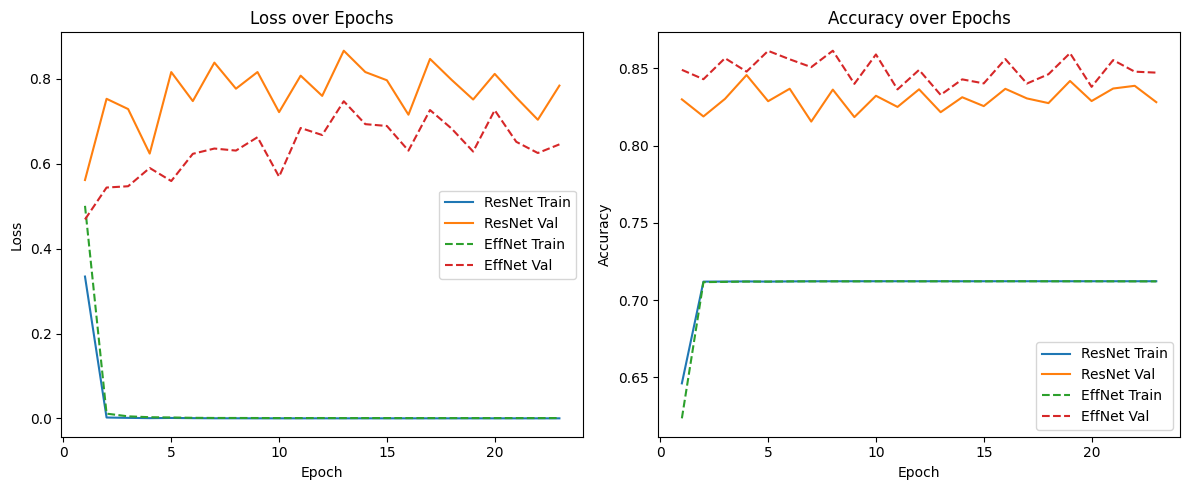

In [12]:
epochs = range(1, len(history['resnet_train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['resnet_train_loss'], label='ResNet Train')
plt.plot(epochs, history['resnet_val_loss'], label='ResNet Val')
plt.plot(epochs, history['effnet_train_loss'], label='EffNet Train', linestyle='--')
plt.plot(epochs, history['effnet_val_loss'], label='EffNet Val', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['resnet_train_acc'], label='ResNet Train')
plt.plot(epochs, history['resnet_val_acc'], label='ResNet Val')
plt.plot(epochs, history['effnet_train_acc'], label='EffNet Train', linestyle='--')
plt.plot(epochs, history['effnet_val_acc'], label='EffNet Val', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')